In [1]:
from main import *
from models import *
from hyperparameter import *

2024-09-27 11:52:39.342668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 11:52:39.354032: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 11:52:39.357328: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preprocessing, Visualization, and Train/Val/Test Split

In [2]:
data_dir ='data' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')
print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: data
Training directory: data/Training
Testing directory: data/Testing


In [3]:
# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [4]:
class_names_train = list(train_data.class_indices.keys())
class_names_test = list(test_data.class_indices.keys())
print(class_names_train)

['glioma', 'meningioma', 'notumor', 'pituitary']


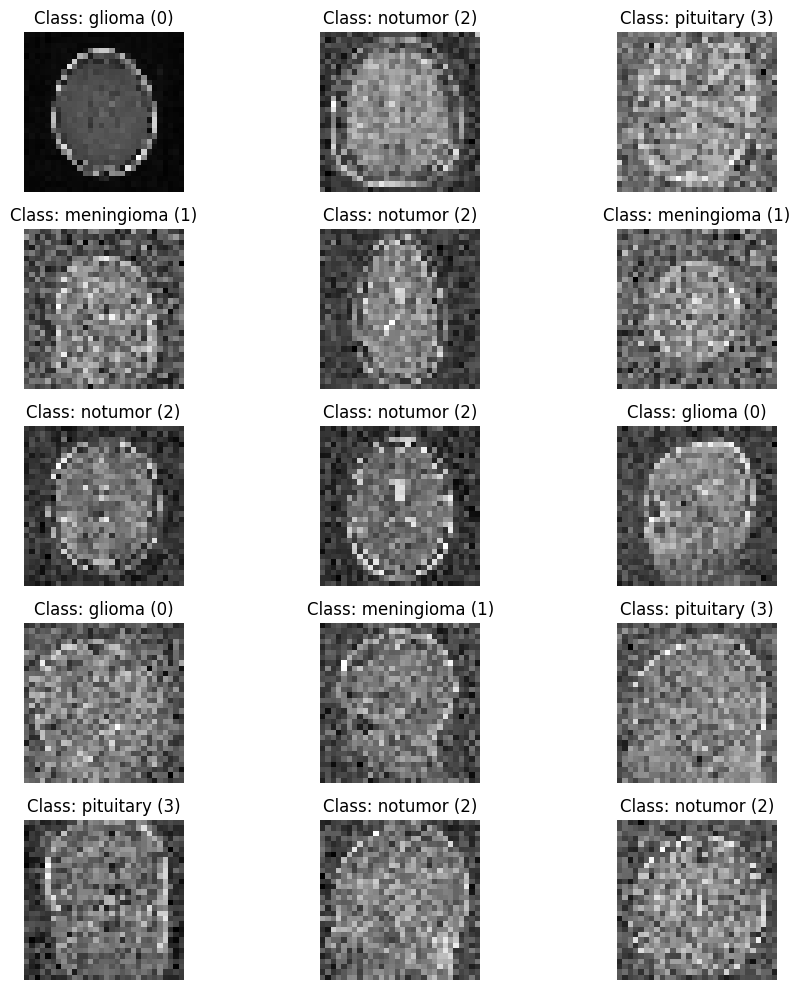

In [5]:
visualize_batch(train_data)

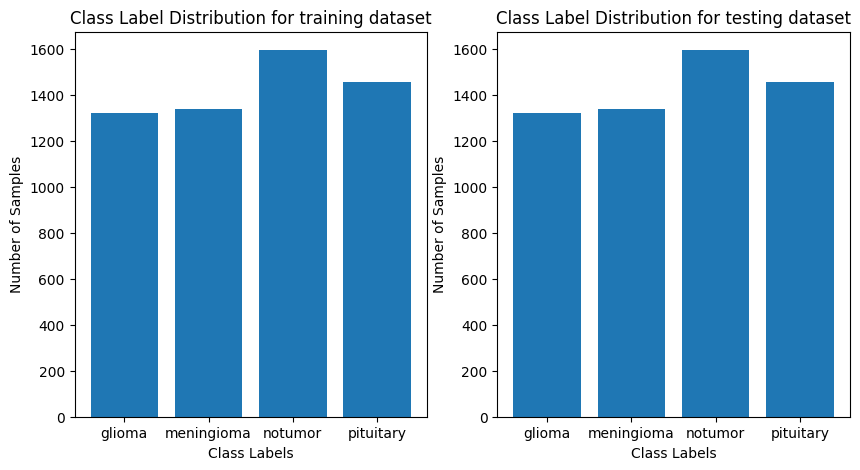

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
plot_class_dist(ax1, train_data, "training")
plot_class_dist(ax2, train_data, "testing")

In [7]:
X_train, y_train, X_val, y_val = train_val_split(train_data)
X_test, y_test = test_splits(test_data)

Number of batches in the training data: 179
Batch size of a single batch 32
Number of samples in the training dataset 5712

Number of training data batches with val split of 0.2: 144
Number of validation data batches: 35



I0000 00:00:1727430765.477405    4079 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727430765.500775    4079 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727430765.500820    4079 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727430765.503208    4079 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727430765.503266    4079 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Shape of image training set: (4608, 30, 30, 1)
Shape of image validation set: (1104, 30, 30, 1)

Shape of label training set: (4608, 4)
Shape of label validation set: (1104, 4)
Number of batches in the test data: 41
Batch size of a single batch 32
Number of samples in the test dataset 1311

Shape of image test set: (1311, 30, 30, 1)

Shape of label test set: (1311, 4)


In [ ]:
def get_metrics(models, X, y, index):
    
    """
    Returns a dataframe with metrics and another with f1 per class.

    Parameters:
    - models: A list of models
    - X: Feature data (validation or test set)
    - y: True labels for the dataset
    - index: An iterable of class labels
    """
    list_metr = []
    list_f1 = []
    for model in models:
        dict = model.evaluate(X, y, batch_size = 32, return_dict = True)
        dict.pop("loss")
        list_f1.append(pd.Series(dict.pop("F1Score"), index = index))
        list_metr.append(dict)
    f1 = pd.DataFrame(list_f1).T
    metr = pd.DataFrame(list_metr).T
    return metr, f1

In [ ]:
cnn = cnn300k()
resnet = resnet()

In [ ]:
earl

# Baseline Model

In [8]:
%
base = baseline()
history = base.fit(X_train, y_train, batch_size =32, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10


I0000 00:00:1727430767.940997    4176 service.cc:146] XLA service 0x7fc5fc0051c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727430767.941030    4176 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6


 47/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.2447 - accuracy: 0.3343 - loss: 1.3154 - precision: 0.4325 - recall: 0.0116       

I0000 00:00:1727430769.876625    4176 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - F1Score: 0.4201 - accuracy: 0.4631 - loss: 1.1677 - precision: 0.6522 - recall: 0.1519 - val_F1Score: 0.6675 - val_accuracy: 0.6839 - val_loss: 0.8158 - val_precision: 0.7386 - val_recall: 0.5734
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - F1Score: 0.7120 - accuracy: 0.7233 - loss: 0.7419 - precision: 0.7839 - recall: 0.6196 - val_F1Score: 0.7061 - val_accuracy: 0.7201 - val_loss: 0.6974 - val_precision: 0.7718 - val_recall: 0.6585
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - F1Score: 0.7400 - accuracy: 0.7524 - loss: 0.6322 - precision: 0.8077 - recall: 0.6942 - val_F1Score: 0.7371 - val_accuracy: 0.7509 - val_loss: 0.6418 - val_precision: 0.7940 - val_recall: 0.6911
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.7637 - accuracy: 0.7745 - loss: 0.5968 - precision: 0.8190 - recall: 0.7250 - val_F1Score: 0.7122 - val_accuracy: 0.7174 - val_loss: 0.7100 - val_precision: 0.7453 - val_recall: 0.6812
Epoch 5/10

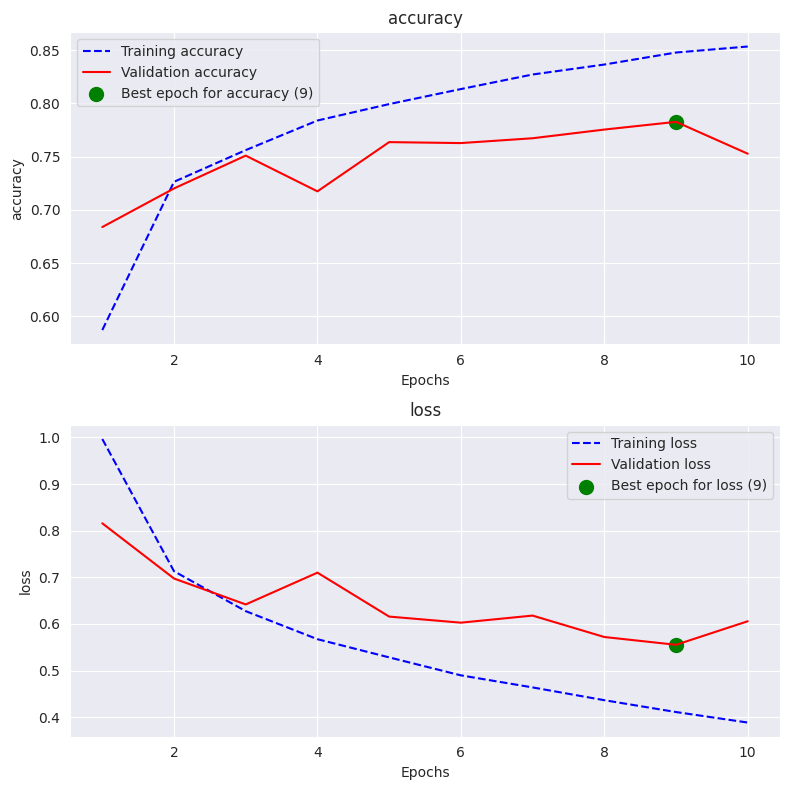

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


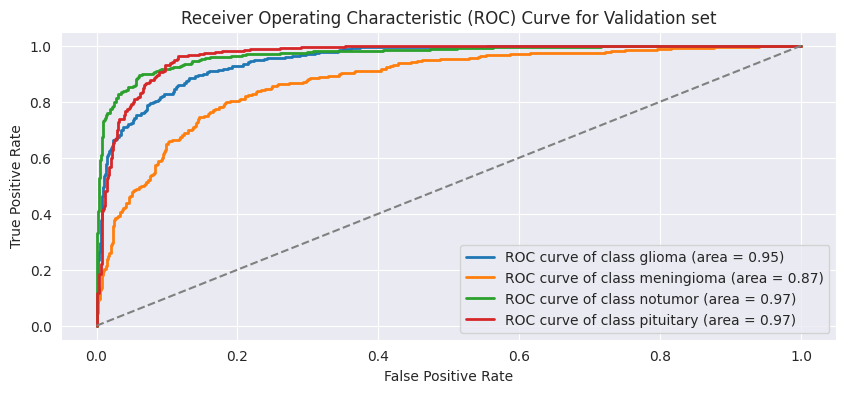

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


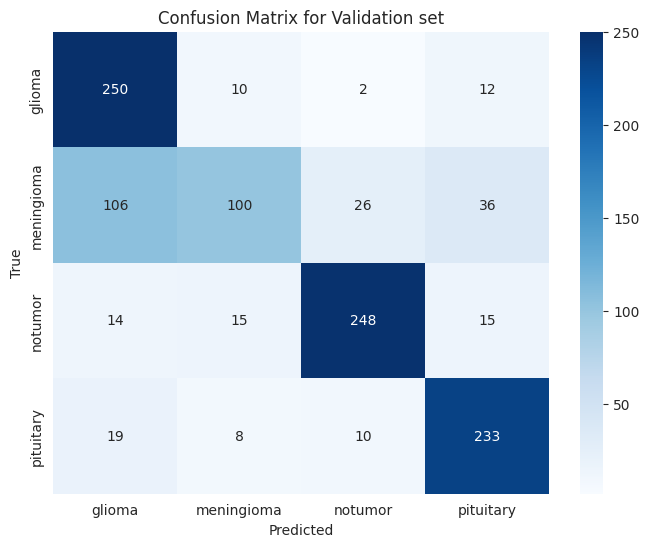

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


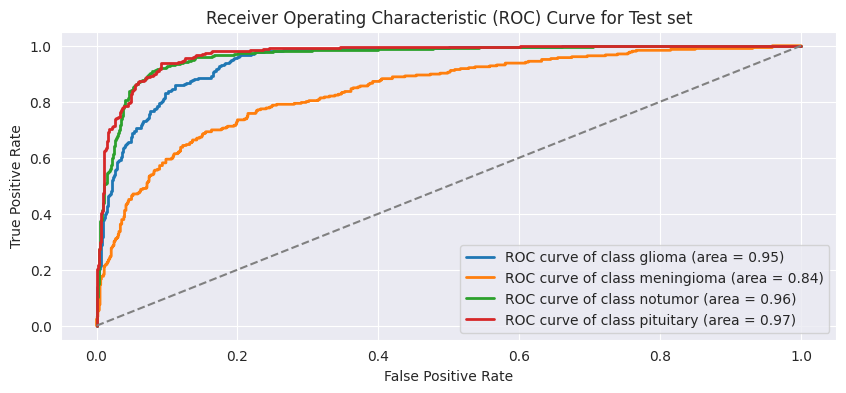

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


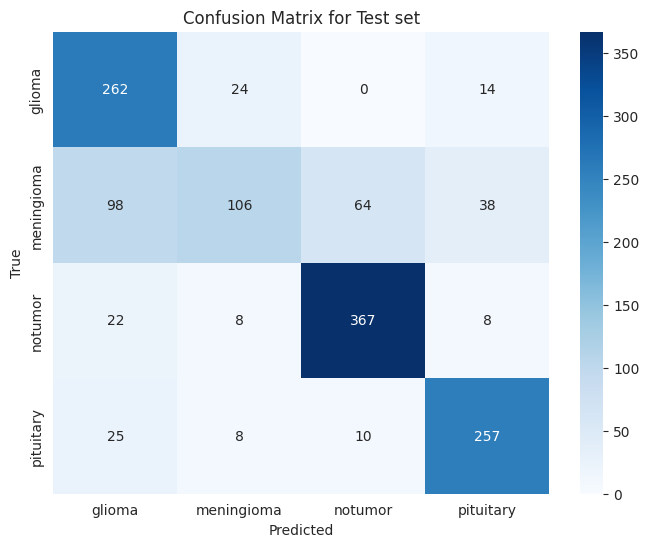

In [9]:
summarize_metric(history)

plot_roc_curve(base, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(base, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')

plot_roc_curve(base, X_test, y_test, class_names_test, title = 'Test set')
plot_confusion_matrix(base, X_test, y_test, class_names_test, normalize=False, title = 'Test set')

In [10]:
models = [base]

metrics, f1 = get_metrics(models, X_test, y_test, class_names_test)
display(metrics.rename(columns = {0: "Baselinemodel"}))
display(f1.rename(columns = {0: "F1"}))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - F1Score: 0.4534 - accuracy: 0.7485 - loss: 0.6301 - precision: 0.7659 - recall: 0.7300


,Baselinemodel
accuracy,0.756674
precision,0.779839
recall,0.737605


,F1
glioma,0.741160
meningioma,0.469026
notumor,0.867612
pituitary,0.833063
